# Deep Convolutional Generative Adversarial Network

## Setup

### Import packages 

In [149]:
import os
import glob
import datetime

import imageio
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

print("%d GPUs are available for tensorflow %s in current environment." % 
      (len(tf.config.experimental.list_physical_devices('GPU')), tf.__version__))

0 GPUs are available for tensorflow 2.0.0 in current environment.


In [7]:
# import PIL
# import time
# from IPython import display

### Load and prepare the dataset

In [14]:
(mnist_train, _), (mnist_test, _) = tf.keras.datasets.mnist.load_data()
print("shape of MNIST images is: " + str(mnist_train.shape))

shape of MNIST images is: (60000, 28, 28)


In [18]:
def preprocess(x):
    x = 2*tf.cast(x, dtype=tf.float32)/255 - 1
    x = tf.expand_dims(x, axis=-1)
    
    return x

In [100]:
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [34]:
mnist_train_db = tf.data.Dataset.from_tensor_slices(mnist_train)
mnist_train_db = mnist_train_db.map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

mnist_test_db = tf.data.Dataset.from_tensor_slices(mnist_test)
mnist_test_db = mnist_test_db.map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [168]:
samples = next(iter(mnist_train_db))
print("shape of one batch for MNIST images is: " + str(samples.shape))

shape of one batch for MNIST images is: (256, 28, 28, 1)


## Define the Generator and Discriminator

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [44]:
class Generator(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.fc0 = layers.Dense(7*7*256, use_bias=False)
        self.bn0 = layers.BatchNormalization()
        
        self.conv1 = layers.Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        
        self.conv2 = layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        
        self.conv3 = layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', use_bias=False)
        
    # [b, 100] -> [b, 64, 64, 3]  
    def call(self, inputs, training=None):
        x = self.fc0(inputs)   
        assert x.shape == (BATCH_SIZE, 7*7*256)
        x = tf.reshape(x, [-1, 7, 7, 256]) 
        x = tf.nn.leaky_relu(x)
        
        x = tf.nn.leaky_relu(self.bn1(self.conv1(x), training=training))
        assert x.shape == (BATCH_SIZE, 7, 7, 128)
        
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        assert x.shape == (BATCH_SIZE, 14, 14, 64)
        
        image = tf.math.tanh(self.conv3(x))
        assert image.shape == (BATCH_SIZE, 28, 28, 1)
        
        return image

In [46]:
generator = Generator()
seed = tf.random.normal([BATCH_SIZE, 100])
image_fake = generator(seed, training=False)
print("The shape of the output of the generator is: " + str(image_fake.shape))

The shape of the output of the generator is: (256, 28, 28, 1)


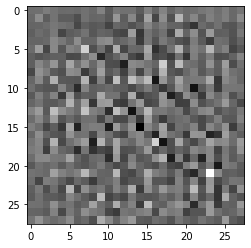

In [48]:
plt.imshow(image_fake[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

The discriminator is a CNN-based image classifier.

In [49]:
class Discriminator(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same')
        self.dropout1 = layers.Dropout(0.3)
        
        self.conv2 = layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.3)
        
        self.conv3 = layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.3)
        
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(1)
        
    def call(self, inputs, training=None):
        x = tf.nn.leaky_relu(self.dropout1(self.conv1(inputs)))
        x = self.dropout2(tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training)))
        x = self.dropout3(tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training)))
        
        x = self.flatten(x)
        logits = self.fc(x)
        
        return logits

In [53]:
discriminator = Discriminator()
logit = discriminator(image_fake, training=False)
print("The shape of logit given by discriminator is: " + str(logit.shape))

The shape of logit given by discriminator is: (256, 1)


## Define the Loss Calculator

Define loss functions and optimizers for both models.


In [84]:
loss_cal = tf.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [91]:
def discriminator_loss_cal(generator, discriminator, seed, image_true, training):
    
    image_fake = generator(seed, training)
    
    # treat real image as real
    logits_real = discriminator(image_true, training)
    loss_real = tf.reduce_mean(loss_cal(tf.ones_like(logits_real), logits_real))
    # treat fake image as fake
    logits_fake = discriminator(image_fake, training)
    loss_fake = tf.reduce_mean(loss_cal(tf.zeros_like(logits_fake), logits_fake))  
    loss = loss_fake + loss_real
    
    return loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

The discriminator and the generator optimizers are different since we will train two networks separately.

In [92]:
def generator_loss_cal(generator, discriminator, seed, training):
    
    image_fake = generator(seed, training)
    logits_fake = discriminator(image_fake, training)
    
    loss = tf.reduce_mean(loss_cal(tf.ones_like(logits_fake), logits_fake))     
    return loss

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [130]:
checkpoint_prefix

'..\\outputs\\training_checkpoints\\20191123-164909\\ckpt'

In [208]:
def save_image(images, height, width, image_path, step):

    images = ((images + 1.0) * 127.5).astype(np.uint8)
    # final picture which save as PNG
    picture = np.array([])
    
    row = np.array([])
    for i in range(height*width):
        # concat image into a row
        if row.size == 0:
            row = images[i]
        else:
            row = np.concatenate((row, images[i]), axis=1)

        # concat image row to picture
        if (i+1) % width == 0:
            if picture.size == 0:
                picture = row
            else:
                picture = np.concatenate((picture, row), axis=0)
            # reset single row
            row = np.array([])
    
    picture_board = tf.expand_dims(tf.cast(picture, dtype=tf.uint8), 0)
    with summary_writer.as_default(): 
        tf.summary.image('train-fake-images:', picture_board, step=step)
    
    picture = np.squeeze(picture, axis=2)
    Image.fromarray(picture, 'P').save(image_path)

## Define the training loop



In [141]:
EPOCH = 50
STEP = 5
SEED = 100
LEARNING_RATE = 1e-4

In [132]:
generator_optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [143]:
# the time stamp
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# save the training process
checkpoint_dir = "..\\outputs\\training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, stamp, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# the log file created for tensorborad
log_dir = os.path.join("..\\outputs\\logs", stamp)
summary_writer = tf.summary.create_file_writer(log_dir) 

In [209]:
# number of batches have trained
index = 0
for epoch in range(EPOCH):
    
    for step, image_true in enumerate(mnist_test_db):
        
        seed = tf.random.uniform([BATCH_SIZE, SEED], minval=-1, maxval=1)
        # train Discriminator
        with tf.GradientTape() as tape:
            discriminator_loss = discriminator_loss_cal(generator, discriminator, seed, image_true, training=True)
        grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
        discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
        
        # train Generator
        with tf.GradientTape() as tape:
            generator_loss = generator_loss_cal(generator, discriminator, seed, training=True)
        grads = tape.gradient(generator_loss, generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))     
        
        if step % STEP == 0:
            index += 1
            print("At epoch: %s/%d, after %s batches have been trained: discriminator loss: %.5f, generator loss: %.5f" % 
                  (format(epoch, '2'), EPOCH, format(step,'2'), float(discriminator_loss), float(generator_loss)))
            
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            with summary_writer.as_default(): 
                tf.summary.scalar('train-generator-loss', float(generator_loss), step=index) 
                tf.summary.scalar('train-discriminator-loss', float(discriminator_loss), step=index) 
                
            fake_image = generator(seed, training=False)
            img_path = os.path.join("..\\outputs\\images\\GAN", 'index-%d.png' % index)
            save_image(fake_image.numpy(), 5, 5, img_path, step)

At epoch:  0/50, after  0 batches have been trained: discriminator loss: 0.00550, generator loss: 9.48571
At epoch:  0/50, after  5 batches have been trained: discriminator loss: 0.02802, generator loss: 8.07097
At epoch:  0/50, after 10 batches have been trained: discriminator loss: 0.02986, generator loss: 9.83478
At epoch:  0/50, after 15 batches have been trained: discriminator loss: 0.00292, generator loss: 8.37769
At epoch:  0/50, after 20 batches have been trained: discriminator loss: 0.00633, generator loss: 9.14631
At epoch:  0/50, after 25 batches have been trained: discriminator loss: 0.00251, generator loss: 11.22885
At epoch:  0/50, after 30 batches have been trained: discriminator loss: 0.00022, generator loss: 12.39377
At epoch:  0/50, after 35 batches have been trained: discriminator loss: 0.00035, generator loss: 12.03031
At epoch:  1/50, after  0 batches have been trained: discriminator loss: 0.00015, generator loss: 11.40330
At epoch:  1/50, after  5 batches have bee

KeyboardInterrupt: 

**Generate and save images**



In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


Use `imageio` to create an animated gif using the images saved during training.

In [218]:
anim_file = '..\\outputs\\images\\GAN\\dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("..\\outputs\\images\\GAN\\*.png")
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

If you're working in Colab you can download the animation with the code below:

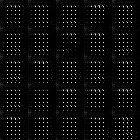

In [230]:
display.Image(filename=anim_file)